In [254]:
using ModelingToolkit
using OrdinaryDiffEq
using DifferentialEquations
using AlgebraicPetri
using AlgebraicPetri.Epidemiology
using AlgebraicPetri.BilayerNetworks

using Plots
using Random

using Catlab
using Catlab.CategoricalAlgebra
using Catlab.Graphics
import Catlab.CategoricalAlgebra: migrate!
using Catlab.WiringDiagrams
using Catlab.Programs.RelationalPrograms

using JSON

using Dates

In [255]:
make_depvar(p,t) = :($p($t))

make_depvar (generic function with 1 method)

In [256]:
function compile(bn::Union{AbstractLabelledBilayerNetwork, AbstractBilayerNetwork})
  varstmt = :(@variables t)
  varnames = bn[:variable]
  append!(varstmt.args, make_depvar.(bn[:variable], :t))

  paramstmt = :(@parameters)
  params = bn[:parameter]
  append!(paramstmt.args, bn[:parameter])

  diffstmt = :(_D_ = Differential(t))

  ϕs = map(parts(bn, :Box)) do b
    vars = map(incident(bn, b,:call)) do i
      j = bn[i, :arg]
      return bn[j, :variable]
    end
    p = :(*($(bn[b, :parameter])))
    append!(p.args, vars)
    return :($(Symbol("ϕ$b")) = $p)
  end

  infs = map(parts(bn, :Qout)) do tv
    vars = map(incident(bn, tv, :infusion)) do wa
      j = bn[wa, :influx]
      return Symbol("ϕ$j")
    end
    p = :(+())
    append!(p.args, vars)

    # same for the outfluxes
    vars = map(incident(bn, tv, :effusion)) do wn
      j = bn[wn, :efflux]
      return :(- $(Symbol("ϕ$j")))
    end
    append!(p.args, vars)
    return p
  end

  zparts = zip(bn[:tanvar], infs)

  eqns = [:(_D_($tanvar) ~ $rhs) for (tanvar, rhs) in zparts]
  eq = :([])
  append!(eq.args, eqns)
  eqnstmt = :(eqs = $eq)

  varnameexpr = Expr(:tuple, varnames...)
  parnameexpr = Expr(:tuple, params...)

  return quote
    $varstmt
    $paramstmt
    $diffstmt
    $(ϕs...)
    $eqnstmt
    return $varnameexpr, $parnameexpr, ODESystem(eqs, t, name=:PetriNet)
  end
end

compile (generic function with 1 method)

In [257]:
@present TheoryOrigMIRANet <: SchLabelledReactionNet begin
    MID::AttrType
    MCTX::AttrType
    Template::AttrType
    mira_ids::Attr(S, MID)
    mira_context::Attr(S, MCTX)
    mira_initial_value::Attr(S, Concentration)
    template_type::Attr(T, Template)
    parameter_name::Attr(T, Name)
    parameter_value::Attr(T, Rate)
end
@abstract_acset_type AbstractOrigMIRANet <: AbstractLabelledReactionNet
@acset_type OrigMIRANet(TheoryOrigMIRANet) <: AbstractOrigMIRANet

OrigMIRANet

In [258]:
function mtk_simulate(jsonfile, states, params, timespan)
    mira = read_json_acset(OrigMIRANet{Any,Any,Any,Any,Any,Any}, jsonfile)
    map!(Symbol, mira[:sname], mira[:sname])
    map!(Symbol, mira[:tname], mira[:tname])
    bnsir = LabelledBilayerNetwork()
    migrate!(bnsir, LabelledPetriNet(mira))
    mdl = eval(compile(bnsir))
    prob = ODEProblem(mdl[3], states, timespan, params)
    soln = solve(prob)
    return soln
end

mtk_simulate (generic function with 1 method)

In [437]:
# Set RNG seed
Random.seed!(1234);

# Constants
num_timesteps = 120 + 1
timespan = (0, num_timesteps - 1)
num_runs = 10

df = Dates.DateFormat("yyyy-mm-ddTHH:MM:SS")
start_datetime = DateTime(2022, 1, 1, 0, 0)
delta = DateTime(2022, 1, 2, 0, 0) - DateTime(2022, 1, 1, 0, 0)

# Run simulation for every available model

for source in ["biomodels", "starter-kit"]

    for model_dir in readdir(joinpath("./thin-thread-examples", source), join = true)

        root, dirs, files = first(walkdir(model_dir))

        if "model_petri.json" in files

            p_model = joinpath(model_dir, "model_petri.json")
            model = JSON.parsefile(p_model)    
            num_states = length(model["S"])
            num_params = length(model["T"])

            # Iterate over runs
            for i_run in 0:num_runs

                # Run with default values in model
                if i_run == 0

                    mmt_params = JSON.parsefile(joinpath(model_dir, "model_mmt_parameters.json"))
                    mmt_initials = JSON.parsefile(joinpath(model_dir, "model_mmt_initials.json"))

                    # Get default model parameter values
                    params = Vector{Float64}(undef, length(model["T"]))
                    for i in 1:length(model["T"])    
                        if ~isnothing(model["T"][i]["parameter_value"])
                            if typeof(model["T"][i]["parameter_value"]) == typeof(params[i])
                                params[i] = model["T"][i]["parameter_value"]
                            else
                                params[i] = parse(Float64, model["T"][i]["parameter_value"])
                            end
                        else
                            params[i] = 0.0
                        end
                    end

                    # Get default initial condition values
                    initials = Vector{Float64}(undef, length(model["S"]))
                    for i in 1:length(model["S"])
                        if "mira_initial_value" in keys(model["S"][i])
                            if ~isnothing(model["S"][i]["mira_initial_value"])
                                if typeof(model["S"][i]["mira_initial_value"]) == typeof(initials[i])
                                    initials[i] = model["S"][i]["mira_initial_value"]
                                else
                                    initials[i] = parse(Float64, model["S"][i]["mira_initial_value"])
                                end
                            else
                                initials[i] = 0.0
                            end
                        else
                            initials[i] = 0.0
                        end
                    end

                # Run with random values
                else

                    initials = rand(num_states)
                    initials = initials / sum(initials)
                    
                    params = rand(num_params)

                end

                # Run simulation
                soln = mtk_simulate(p_model, initials, params, timespan)
                soln_ = soln(collect(timespan[1]:1:timespan[2]))
                
                # Map results to output format  
                output = deepcopy(mmt_initials["initials"])
                for i in 1:length(model["S"])
                    output[model["S"][i]["sname"]]["value"] = Vector{Float64}(undef, length(soln_.t))
                    for t in 1:length(soln_.t)
                        output[model["S"][i]["sname"]]["value"][t] = soln_.u[t][i]
                    end
                end

                # Time
                output["_time"] = Dict("name" => "time", "identifiers" => Dict(), "context" => Dict(), "value" => Vector{String}(undef, length(soln_.t)))
                for t in 1:length(soln_.t)
                    output["_time"]["value"][t] = Dates.format(start_datetime + delta * (t - 1), df)
                end

                # Convert `params` to MIRA file format
                params_data = Dict("parameters" => Dict())
                for i in 1:length(model["T"])
                    k = model["T"][i]["parameter_name"]
                    if k in keys(mmt_params["parameters"])
                        params_data["parameters"][k] = mmt_params["parameters"][k]
                        params_data["parameters"][k]["value"] = params[i]
                    else
                        params_data["parameters"][model["T"][i]["tname"]] = Dict("name" => k, "identifiers" => Dict(), "context" => Dict(), "value" => params[i])
                    end
                end

                # Convert `initials` to MIRA file format
                initials_data = Dict("initials" => Dict())
                for i in 1:length(model["S"])
                    k = model["S"][i]["sname"]
                    if k in keys(mmt_initials["initials"])
                        initials_data["initials"][k] = mmt_initials["initials"][k]
                        initials_data["initials"][k]["value"] = initials[i]
                    else
                        initials_data["initials"][k] = Dict("name" => k, "identifiers" => Dict(), "context" => Dict(), "value" => initials[i])
                    end
                end 
                
                # Make output directory
                dir_name = string(i_run)
                p_output = joinpath(model_dir, "runs", dir_name)
                if ~isdir(p_output)
                    mkpath(p_output)
                end
                
                # Serialize and write to file
                open(joinpath(p_output, "parameters.json"), "w") do f
                    JSON.print(f, params_data)
                end

                open(joinpath(p_output, "initials.json"), "w") do f
                    JSON.print(f, initials_data)
                end

                open(joinpath(p_output, "output.json"), "w") do f
                    JSON.print(f, output)
                end

            end

            print("Success: $model_dir\n")

        else

            print("Error: missing `model_petri.json` in $model_dir\n")

        end
    end
end

Success: ./thin-thread-examples/biomodels/BIOMD0000000955
Success: ./thin-thread-examples/biomodels/BIOMD0000000956
Success: ./thin-thread-examples/biomodels/BIOMD0000000957
Success: ./thin-thread-examples/biomodels/BIOMD0000000958
Success: ./thin-thread-examples/biomodels/BIOMD0000000960
Success: ./thin-thread-examples/biomodels/BIOMD0000000962
Success: ./thin-thread-examples/biomodels/BIOMD0000000963
Success: ./thin-thread-examples/biomodels/BIOMD0000000964
Success: ./thin-thread-examples/biomodels/BIOMD0000000969
Success: ./thin-thread-examples/biomodels/BIOMD0000000970
Success: ./thin-thread-examples/biomodels/BIOMD0000000971
Success: ./thin-thread-examples/biomodels/BIOMD0000000972
Success: ./thin-thread-examples/biomodels/BIOMD0000000974
Success: ./thin-thread-examples/biomodels/BIOMD0000000976
Success: ./thin-thread-examples/biomodels/BIOMD0000000977
Success: ./thin-thread-examples/biomodels/BIOMD0000000978
Success: ./thin-thread-examples/biomodels/BIOMD0000000979
Success: ./thi

In [438]:
# Specific scenarios to run for BIOMD0000000955 (SIDARTHE):

# Parameter meaning:
# α: rate of S -> I, disease transmission caused by Infected
# β: rate of S -> I, disease transmission caused by Diagnosed
# γ: rate of S -> I, disease transmission caused by Ailing
# δ: rate of S -> I, disease transmission caused by Recognized
# ε: rate of I -> D, detection rate of asymptomatic cases
# θ: rate of A -> R, detection rate of symptomatic cases
# ζ: rate of I -> A, rate of developing symptoms by undetected infected (I)
# η: rate of D -> R, rate of developing symptoms by detected infected (D)
# µ: rate of A -> T, rate of developing acute symptoms by undetected infected (A) 
# ν: rate of R -> T, rate of developing acute symptoms by detected infected (R)
# τ: rate of T -> E, rate of death by acutely symptomatic infected (T)
# λ, κ, ξ, ρ, σ: rate of (I, A, R, D, T) -> H, rate of recovery by various infected populations

In [439]:
descriptions = [
    "Baseline scenario for Day 1 of the epidemic, before the introduction of any public health measures; R0 = 2.38; see Fig. 2.", 
    "Baseline scenario for Day 4 to 12 of the epidemic; introduction of basic public health recommendations and government school closures; R0 = 1.66; see Fig. 2.", 
    "Baseline scenario for Day 12 to 22 of the epidemic; policy of limiting screening to symptomatic individuals only; R0 = 1.80; see Fig. 2.",
    "Baseline scenario for Day 22 to 28 of the epidemic; introduction of incomplete lockdown; R0 = 1.60; see Fig. 2.",
    "Baseline scenario for Day 28 to 38 of the epidemic; fully operational lockdown with strict measures (working is no longer a good reason for going out: gradually, non-indispensable activities are stopped); R0 = 0.99; see Fig. 2.",
    "Baseline scenario for Day 38 onwards of the epidemic; wider testing campaign is launched; R0 = 0.85; see Fig. 2.",
    "Future scenario for Day 50 onwards of the epidemic; the lockdown is weakened by increasing the S-I transmission rate `alpha` from 0.210 to 0.252; R0 = 0.98; see Fig. 3a, b.", 
    "Future scenario for Day 50 onwards of the epidemic; the lockdown is strengthened by decreasing the S-I transmission rate `alpha` from 0.210 to 0.105; R0 = 0.50; see Fig. 3c, d.",
    "Future scenario for Day 50 onwards of the epidemic; introduction of population-wide testing and contact tracing by increasing the asymptomatic-case detection rate `epsilon` from 0.200 to 0.400; R0 = 0.59; see Fig. 4a, b.",
    "Future scenario for Day 50 onwards of the epidemic; a milder lockdown with widespread testing and contact tracing by increasing the S-I transmission rate `alpha` from 0.210 to 0.420 and increasing the asymptomatic-case detection rate `epsilon` from 0.200 to 0.600; R0 = 0.77; see Fig. 4c, d.",
    "Future scenario for Day 22 onwards of the epidemic; absence of further countermeasures after day 22 (just closing schools and hygiene recommendations); transmission rates `alpha` = 0.422, `gamma` = 0.285 and `beta` = `delta` = 0.0057; R0 = 1.66; see Extended Fig. 1a, b.",
    "Future scenario for Day 22 onwards of the epidemic; social-distancing countermeasures after day 22 having a mild effect; transmission rates `alpha` = 0.285 and `gamma` = 0.171; R0 = 1.13; see Extended Fig. 1c, d.",
    "Future scenario for Day 22 onwards of the epidemic; stronger social-distancing countermeasures; transmission rates `alpha` = 0.200 and `gamma` = 0.086; R0 = 0.787; see Extended Fig. 1e, f.",
    "Future scenario for Day 22 onwards of the epidemic; even stronger social-distancing countermeasures; transmission rates `alpha` = `gamma` = 0.057; R0 = 0.0329; see Extended Fig. 1g, h.",
]

14-element Vector{String}:
 "Baseline scenario for Day 1 of " ⋯ 60 bytes ⋯ "easures; R0 = 2.38; see Fig. 2."
 "Baseline scenario for Day 4 to " ⋯ 95 bytes ⋯ "losures; R0 = 1.66; see Fig. 2."
 "Baseline scenario for Day 12 to" ⋯ 74 bytes ⋯ "ls only; R0 = 1.80; see Fig. 2."
 "Baseline scenario for Day 22 to" ⋯ 49 bytes ⋯ "ockdown; R0 = 1.60; see Fig. 2."
 "Baseline scenario for Day 28 to" ⋯ 166 bytes ⋯ "opped); R0 = 0.99; see Fig. 2."
 "Baseline scenario for Day 38 on" ⋯ 50 bytes ⋯ "aunched; R0 = 0.85; see Fig. 2."
 "Future scenario for Day 50 onwa" ⋯ 111 bytes ⋯ "52; R0 = 0.98; see Fig. 3a, b."
 "Future scenario for Day 50 onwa" ⋯ 115 bytes ⋯ "05; R0 = 0.50; see Fig. 3c, d."
 "Future scenario for Day 50 onwa" ⋯ 159 bytes ⋯ "00; R0 = 0.59; see Fig. 4a, b."
 "Future scenario for Day 50 onwa" ⋯ 230 bytes ⋯ "00; R0 = 0.77; see Fig. 4c, d."
 "Future scenario for Day 22 onwa" ⋯ 225 bytes ⋯ "1.66; see Extended Fig. 1a, b."
 "Future scenario for Day 22 onwa" ⋯ 159 bytes ⋯ "1.13; see Extended Fi

In [440]:
# Get model
model_dir = "./thin-thread-examples/demo/BIOMD0000000955"
p_model = joinpath(model_dir, "model_petri.json")
model = JSON.parsefile(p_model)
num_states = length(model["S"])
num_params = length(model["T"])

print("Number of State Variables = $num_states\n")
print("Number of Parameters = $num_params\n")


# Define scenario parameters

num_scenarios = 14
params = Array{Float64, 2}(undef, num_scenarios, num_params)
#               alpha  beta   gamma  delta   epsilon zeta   lambda eta    rho    theta  kappa  mu     nu     xi     tau   sigma
# Day 1
params[1, :] = [0.570, 0.0110, 0.456, 0.0011, 0.171, 0.125, 0.034, 0.125, 0.034, 0.371, 0.017, 0.017, 0.027, 0.017, 0.01, 0.017]

# Day 4
params[2, :] = [0.422, 0.0057, 0.285, 0.0057, 0.171, 0.125, 0.034, 0.125, 0.034, 0.371, 0.017, 0.017, 0.027, 0.017, 0.01, 0.017]

# Day 12
params[3, :] = [0.422, 0.0057, 0.285, 0.0057, 0.143, 0.125, 0.034, 0.125, 0.034, 0.371, 0.017, 0.017, 0.027, 0.017, 0.01, 0.017]

# Day 22
params[4, :] = [0.360, 0.0050, 0.200, 0.0050, 0.143, 0.0034, 0.08, 0.0034, 0.017, 0.371, 0.017, 0.008, 0.015, 0.017, 0.01, 0.017]

# Day 28
params[5, :] = [0.210, 0.0050, 0.110, 0.0050, 0.143, 0.0034, 0.08, 0.0034, 0.017, 0.371, 0.017, 0.008, 0.015, 0.017, 0.01, 0.017]

# Day 38
params[6, :] = [0.210, 0.0050, 0.110, 0.0050, 0.200, 0.0025, 0.08, 0.0025, 0.020, 0.371, 0.020, 0.008, 0.015, 0.020, 0.01, 0.010]

# Day 50, weakened lockdown
params[7, :] = [0.252, 0.0050, 0.110, 0.0050, 0.200, 0.0025, 0.08, 0.0025, 0.020, 0.371, 0.020, 0.008, 0.015, 0.020, 0.01, 0.010]

# Day 50, strenghened lockdown
params[8, :] = [0.105, 0.0050, 0.110, 0.0050, 0.200, 0.0025, 0.08, 0.0025, 0.020, 0.371, 0.020, 0.008, 0.015, 0.020, 0.01, 0.010]

# Day 50, pop-wide testing
params[9, :] = [0.210, 0.0050, 0.110, 0.0050, 0.400, 0.0025, 0.08, 0.0025, 0.020, 0.371, 0.020, 0.008, 0.015, 0.020, 0.01, 0.010]

# Day 50, milder lockdown with widespread testing
params[10, :] = [0.420, 0.0050, 0.110, 0.0050, 0.600, 0.0025, 0.08, 0.0025, 0.020, 0.371, 0.020, 0.008, 0.015, 0.020, 0.01, 0.010]

# Day 22, no further countermeasures
params[11, :] = [0.422, 0.0057, 0.285, 0.0057, 0.143, 0.125, 0.034, 0.125, 0.034, 0.371, 0.017, 0.017, 0.027, 0.017, 0.01, 0.017]

# Day 22, social-distancing countermeasures having milder effect
params[12, :] = [0.285, 0.0057, 0.171, 0.0057, 0.143, 0.125, 0.034, 0.125, 0.034, 0.371, 0.017, 0.017, 0.027, 0.017, 0.01, 0.017]

# Day 22, stronger social-distancing measures
params[13, :] = [0.200, 0.0057, 0.086, 0.0057, 0.143, 0.125, 0.034, 0.125, 0.034, 0.371, 0.017, 0.017, 0.027, 0.017, 0.01, 0.017]

# Day 22, even stronger social-distancing measures
params[14, :] = [0.057, 0.0057, 0.057, 0.0057, 0.143, 0.125, 0.034, 0.125, 0.034, 0.371, 0.017, 0.017, 0.027, 0.017, 0.01, 0.017]

Number of State Variables = 8
Number of Parameters = 16


16-element Vector{Float64}:
 0.057
 0.0057
 0.057
 0.0057
 0.143
 0.125
 0.034
 0.125
 0.034
 0.371
 0.017
 0.017
 0.027
 0.017
 0.01
 0.017

In [441]:
mira = read_json_acset(OrigMIRANet{Any,Any,Any,Any,Any,Any}, p_model)

T,rate,tname,template_type,parameter_name,parameter_value
1,#undef,t1,ControlledConversion,alpha,0.57
2,#undef,t2,ControlledConversion,beta,0.011
3,#undef,t3,ControlledConversion,gamma,0.456
4,#undef,t4,ControlledConversion,delta,0.011
5,#undef,t5,NaturalConversion,epsilon,0.171
6,#undef,t6,NaturalConversion,zeta,0.125
7,#undef,t7,NaturalConversion,lambda,0.034
8,#undef,t8,NaturalConversion,eta,0.125
9,#undef,t9,NaturalConversion,rho,0.034
10,#undef,t10,NaturalConversion,theta,0.371


In [442]:
# Get default initial condition values
initials = Vector{Float64}(undef, length(model["S"]))
for i in 1:length(model["S"])
    if "mira_initial_value" in keys(model["S"][i])
        if ~isnothing(model["S"][i]["mira_initial_value"])
            if typeof(model["S"][i]["mira_initial_value"]) == typeof(initials[i])
                initials[i] = model["S"][i]["mira_initial_value"]
            else
                initials[i] = parse(Float64, model["S"][i]["mira_initial_value"])
            end
        else
            initials[i] = 0.0
        end
    else
        initials[i] = 0.0
    end
end

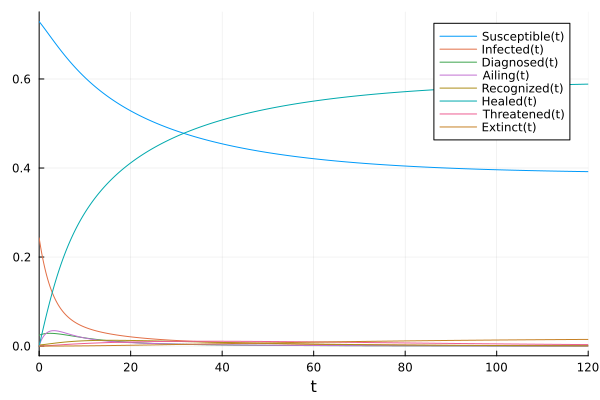

In [443]:
# Trial run
# Need to increase the initial Infected relative population to see any meaningful dynamics?

initials_ = deepcopy(initials)
initials_[2:end] = 1e5 * initials_[2:end]
initials_ = initials_ / sum(initials_)

soln = mtk_simulate(p_model, initials_, params[1, :], timespan)
plot(soln)

In [444]:
# Run scenarios

mmt_params = JSON.parsefile(joinpath(model_dir, "model_mmt_parameters.json"))
mmt_initials = JSON.parsefile(joinpath(model_dir, "model_mmt_initials.json"))

for i_scenario in 1:num_scenarios

    # Run simulation
    soln = mtk_simulate(p_model, initials_, params[i_scenario, :], timespan)
    soln_ = soln(collect(timespan[1]:1:timespan[2]))
    
    # Map results to output format  
    output = deepcopy(mmt_initials["initials"])
    for i in 1:length(model["S"])
        output[model["S"][i]["sname"]]["value"] = Vector{Float64}(undef, length(soln_.t))
        for t in 1:length(soln_.t)
            output[model["S"][i]["sname"]]["value"][t] = soln_.u[t][i]
        end
    end

    # Time
    output["_time"] = Dict("name" => "time", "identifiers" => Dict(), "context" => Dict(), "value" => Vector{String}(undef, length(soln_.t)))
    for t in 1:length(soln_.t)
        output["_time"]["value"][t] = Dates.format(start_datetime + delta * (t - 1), df)
    end

    # Convert `params` to MIRA file format
    params_data = Dict("parameters" => Dict())
    for i in 1:length(model["T"])
        k = model["T"][i]["parameter_name"]
        if k in keys(mmt_params["parameters"])
            params_data["parameters"][k] = mmt_params["parameters"][k]
            params_data["parameters"][k]["value"] = params[i_scenario, i]
        else
            params_data["parameters"][model["T"][i]["tname"]] = Dict("name" => k, "identifiers" => Dict(), "context" => Dict(), "value" => params[i])
        end
    end

    # Convert `initials` to MIRA file format
    initials_data = Dict("initials" => Dict())
    for i in 1:length(model["S"])
        k = model["S"][i]["sname"]
        if k in keys(mmt_initials["initials"])
            initials_data["initials"][k] = mmt_initials["initials"][k]
            initials_data["initials"][k]["value"] = initials_[i]
        else
            initials_data["initials"][k] = Dict("name" => k, "identifiers" => Dict(), "context" => Dict(), "value" => initials[i])
        end
    end 

    # Make output directory
    dir_name = string(i_scenario)
    p_output = joinpath(model_dir, "runs", dir_name)
    if ~isdir(p_output)
        mkpath(p_output)
    end

    # Serialize and write to file
    open(joinpath(p_output, "description.json"), "w") do f
        JSON.print(f, Dict("description" => descriptions[i_scenario]), 4)
    end
    
    open(joinpath(p_output, "parameters.json"), "w") do f
        JSON.print(f, params_data, 4)
    end

    open(joinpath(p_output, "initials.json"), "w") do f
        JSON.print(f, initials_data, 4)
    end

    open(joinpath(p_output, "output.json"), "w") do f
        JSON.print(f, output, 4)
    end
    
end

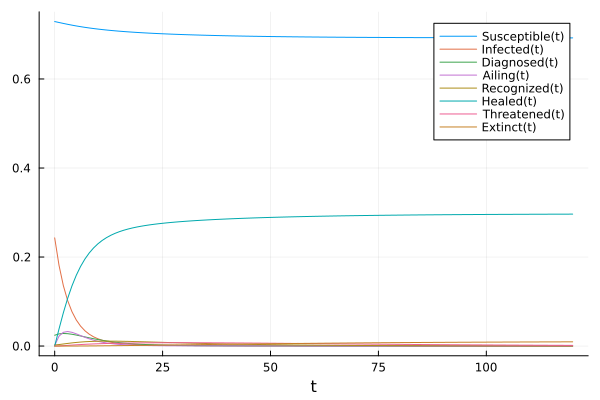

In [445]:
plot(soln_)